A l'occasion du premier tour des élections présidentielles 2017, je vous propose dans ce billet de produire des cartes qui permettent de visualiser les résultats des 11 candidats sur le territoire français. 

Il existe de nombreuses manières différentes de visualiser les données issues du vote. Afin de commencer cette exploration, nous allons tout d'abord essayer de reproduire une visualisation publiée sur le [site du monde](http://www.lemonde.fr/data/france/presidentielle-2017/), qui affiche les résultats par département.

# Par département

Dans [un billet précédent](http://flothesof.github.io/bus-departure-map-Paris.html), j'avais utilisé des fichiers au [format shapefile](https://en.wikipedia.org/wiki/Shapefile) pour dessiner des départements français sur une carte. Nous allons réutiliser la procédure pour faire une carte de ce découpage administratif. Cette fois-ci le fichier shapefile provient du [site de l'IGN](https://wxs-telechargement.ign.fr/oikr5jryiph0iwhw36053ptm/telechargement/inspire/GEOFLA_THEME-DEPARTEMENTS_2016$GEOFLA_2-2_DEPARTEMENT_SHP_LAMB93_FXX_2016-06-28/file/GEOFLA_2-2_DEPARTEMENT_SHP_LAMB93_FXX_2016-06-28.7z).

Nous allons tout d'abord lire les données contenues dans le fichier shapefile pour la France.

In [1]:
import shapefile

In [2]:
r = shapefile.Reader(r"files/departement_shapes/DEPARTEMENT.shp")
shapes = r.shapes()
records = r.records()
fields = r.fields

On va construire une dataframe pandas avec ces objets.

In [3]:
import pandas as pd

In [4]:
df = pd.DataFrame(records, columns=[f[0] for f in fields[1:]])

In [5]:
df.head()

,ID_GEOFLA,CODE_DEPT,NOM_DEPT,CODE_CHF,NOM_CHF,X_CHF_LIEU,Y_CHF_LIEU,X_CENTROID,Y_CENTROID,CODE_REG,NOM_REG
0,DEPARTEM0000000000000001,39,JURA,300,LONS-LE-SAUNIER,895198,6622537,886172,6641548,27,BOURGOGNE-FRANCHE-COMTE
1,DEPARTEM0000000000000002,42,LOIRE,218,SAINT-ETIENNE,808646,6482549,795655,6521581,84,AUVERGNE-RHONE-ALPES
2,DEPARTEM0000000000000003,76,SEINE-MARITIME,540,ROUEN,562355,6928721,550942,6952842,28,NORMANDIE
3,DEPARTEM0000000000000004,89,YONNE,024,AUXERRE,742447,6744261,748211,6750855,27,BOURGOGNE-FRANCHE-COMTE
4,DEPARTEM0000000000000005,68,HAUT-RHIN,066,COLMAR,1024125,6784581,1016174,6763894,44,ALSACE-CHAMPAGNE-ARDENNE-LORRAINE


On va maintenant dessiner les départements dont les informations sont contenues dans ce fichier shapefile.

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection

(71326.0, 1328512.0, 6008968.0, 7159443.0)

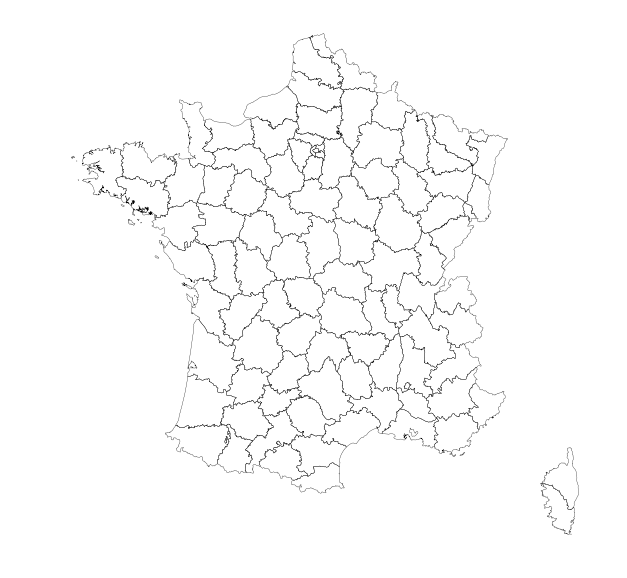

In [7]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

for record, shape in zip(records, shapes):
    lons, lats = zip(*shape.points)
    data = np.array([lons, lats]).T

    if len(shape.parts) == 1:
        segs = [data,]
    else:
        segs = []
        for i in range(1,len(shape.parts)):
            index = shape.parts[i-1]
            index2 = shape.parts[i]
            segs.append(data[index:index2])
        segs.append(data[index2:])

    lines = LineCollection(segs,antialiaseds=(1,))
    lines.set_edgecolors('k')
    lines.set_linewidth(0.3)
    ax.add_collection(lines)
        
        
xmin, xmax = df['X_CHF_LIEU'].min(), df['X_CHF_LIEU'].max()
ymin, ymax = df['Y_CHF_LIEU'].min(), df['Y_CHF_LIEU'].max()
plt.xlim(xmin - 100000, xmax + 100000)
plt.ylim(ymin - 100000, ymax + 100000)
plt.axis('off')

A partir de ce graphique, on va maintenant colorier les départements avec la couleur du candidat dominant. Pour faire ceci, il faut aller chercher les résultats sur le site du ministère de l'intérieur: <http://elections.interieur.gouv.fr/presidentielle-2017/index.html>. De manière assez intéressante, le site du ministère affiche directement les coordonnées des départements dans le code source de sa page et y associe les liens vers les pages de résultats, que l'on peut en extraire.

In [9]:
from bs4 import BeautifulSoup
import requests

In [10]:
soup = BeautifulSoup(requests.get("http://elections.interieur.gouv.fr/presidentielle-2017/index.html").text, 'html.parser')

In [11]:
map_tag = soup.find('map')

In [14]:
area_tags = map_tag.find_all('area')

In [16]:
links = [tag.attrs['href'] for tag in area_tags]

In [20]:
unique_links = set(links)

On peut maintenant aller extraire les données pour chaque candidat à partir de ces liens individuels.

In [61]:
url = "http://elections.interieur.gouv.fr/presidentielle-2017/024/018/index.html"

In [70]:
def extract_candidate_votes(url):
    "Extracts votes for all candidates from a given url."
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    dept = soup.find(class_='span12 pub-fil-ariane').find_all('a')[-1].text
    table = soup.find('tbody')
    results = {}
    for row in table.find_all('tr'):
        results[row.td.text] = int(row.td.next_sibling.next_sibling.text.replace(' ', ''))
    return dept, results

Testons cette fonction :

In [71]:
extract_candidate_votes(url)

('Cher (18)',
 {'M. Benoît HAMON': 9157,
  'M. Emmanuel MACRON': 38076,
  'M. François ASSELINEAU': 1479,
  'M. François FILLON': 32967,
  'M. Jacques CHEMINADE': 345,
  'M. Jean LASSALLE': 1925,
  'M. Jean-Luc MÉLENCHON': 33694,
  'M. Nicolas DUPONT-AIGNAN': 9554,
  'M. Philippe POUTOU': 2106,
  'Mme Marine LE PEN': 41753,
  'Mme Nathalie ARTHAUD': 1630})

Nous pouvons maintenant écrire une boucle pour extraire l'information pour tous les départements.

In [79]:
depts = []
results = []
for link in unique_links:
    dept, result = extract_candidate_votes("http://elections.interieur.gouv.fr/presidentielle-2017/" + link) 
    depts.append(dept)
    results.append(result)

A l'aide de cette information, nous pouvons réconcilier les données géographique et les résultats du vote.

In [80]:
df_votes = pd.DataFrame(results, index=depts)

In [81]:
df_votes

,M. Benoît HAMON,M. Emmanuel MACRON,M. François ASSELINEAU,M. François FILLON,M. Jacques CHEMINADE,M. Jean LASSALLE,M. Jean-Luc MÉLENCHON,M. Nicolas DUPONT-AIGNAN,M. Philippe POUTOU,Mme Marine LE PEN,Mme Nathalie ARTHAUD
Ille-et-Vilaine (35),53418,181373,3994,114034,1021,4531,118096,26822,7065,84648,4339
Oise (60),20525,86680,4666,76783,827,3414,77415,23936,4682,135188,3677
Bouches-du-Rhône (13),47564,203312,9418,207466,1740,10040,231194,40447,8006,286397,4114
Ain (01),16711,73692,3612,69805,595,3465,51736,19788,3098,81455,1842
Seine-et-Marne (77),38772,157314,8195,120968,1247,5182,141827,41505,6354,155521,3706
Hérault (34),36180,128621,5919,110339,894,8461,143996,23159,5660,161119,2496
Haute-Loire (43),7435,32821,1050,25956,282,3112,25419,8346,1928,32185,1043
Haut-Rhin (68),18694,79798,5217,90237,1010,5004,57856,28562,4727,109704,3101
Seine-Maritime (76),41516,145756,5205,118336,1278,4383,152394,33036,8321,170945,5356
Isère (38),43652,164091,6558,112927,1140,6537,135949,33773,6382,147910,3595


On peut trier ce tableau par nombre de votants total dans le département.

In [121]:
vote_sum = df_votes.sum(axis=1).sort_values(ascending=False)

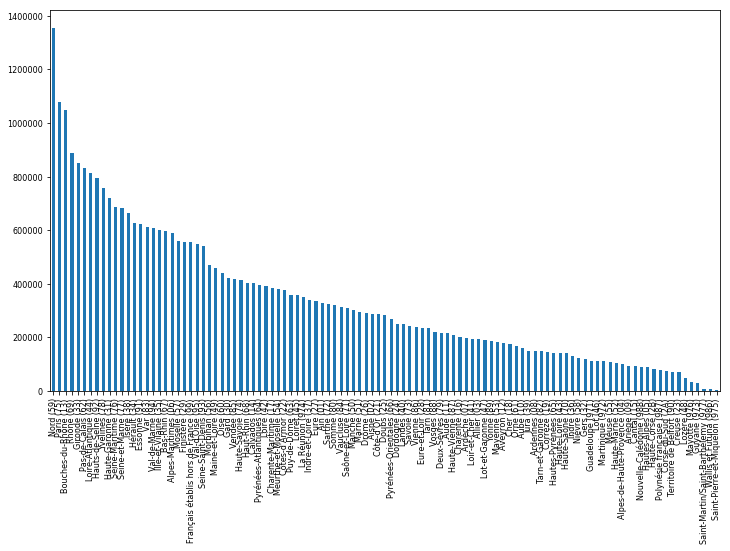

In [124]:
fig, ax = plt.subplots(figsize=(12, 7))
vote_sum.plot.bar(ax=ax, fontsize=8)

In [128]:
df_votes['total'] = vote_sum

In [132]:
df_votes = df_votes.sort_values(by='total', ascending=False)

In [137]:
df_votes = df_votes.drop('total', 1)

Ceci nous permet par exemple de faire le tableau suivant :

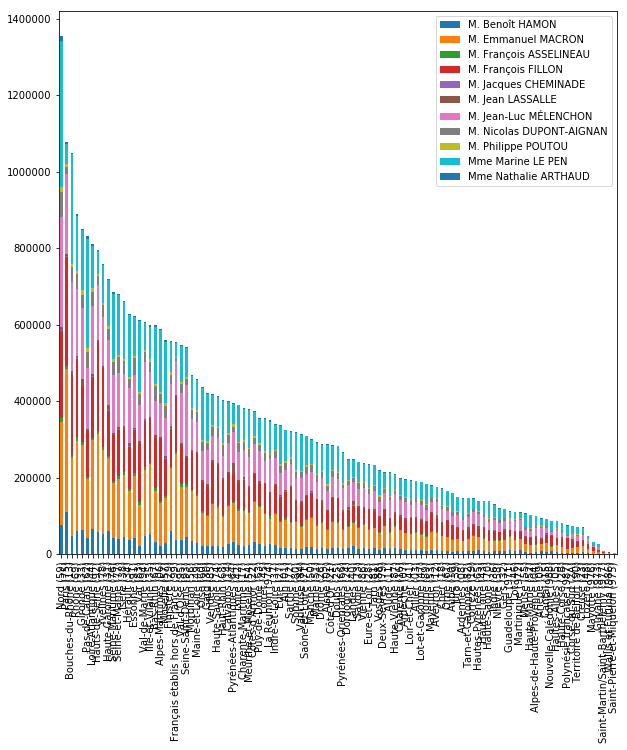

In [138]:
fig, ax = plt.subplots(figsize=(10, 10))
df_votes.plot.bar(rot=90, ax=ax, stacked=True)

Enfin, on peut combiner les informations géographiques et aboutir à la représentation de la carte colorée obtenue par Le Monde :

In [149]:
candidate_colors = np.linspace(0, 1, 20)

In [168]:
cmap = plt.get_cmap('Vega20_r')

(71326.0, 1328512.0, 6008968.0, 7159443.0)

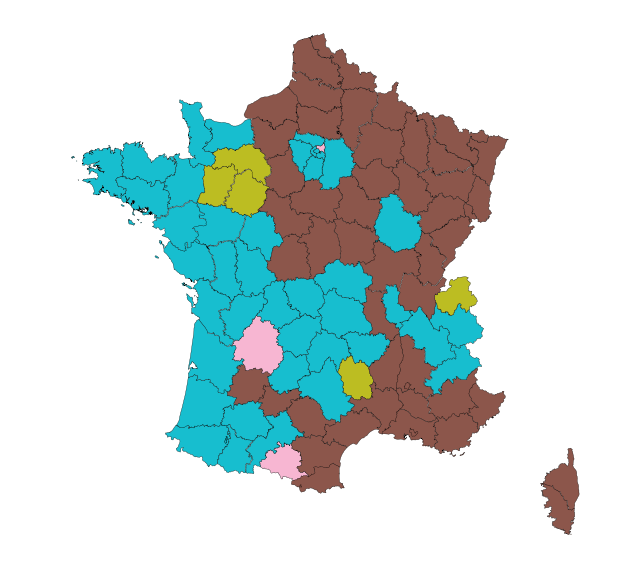

In [171]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
idxs = []
for record, shape, code_dpt in zip(records, shapes, df['CODE_DEPT']):
    lons, lats = zip(*shape.points)
    data = np.array([lons, lats]).T

    if len(shape.parts) == 1:
        segs = [data,]
    else:
        segs = []
        for i in range(1,len(shape.parts)):
            index = shape.parts[i-1]
            index2 = shape.parts[i]
            segs.append(data[index:index2])
        segs.append(data[index2:])

    lines = LineCollection(segs, antialiaseds=(1,))
    lines.set_edgecolors('k')
    lines.set_linewidth(0.3)
    
    values = df_votes[df_votes.index.str.contains(code_dpt)].values
    idx = np.argmax(values)
    idxs.append(idx)
    facecolor = cmap(candidate_colors[idx])
    lines.set_facecolor(facecolor)
    ax.add_collection(lines)
        
        
xmin, xmax = df['X_CHF_LIEU'].min(), df['X_CHF_LIEU'].max()
ymin, ymax = df['Y_CHF_LIEU'].min(), df['Y_CHF_LIEU'].max()
plt.xlim(xmin - 100000, xmax + 100000)
plt.ylim(ymin - 100000, ymax + 100000)
plt.axis('off')
mappable = 
plt.colorbar(mappable)